
# Analysis of the GunPoint dataset


This practical's aim is to analyze the `GunPoint` dataset included in the Python package 
[`pyts`](https://pyts.readthedocs.io/en/stable/index.html). This dataset involves one female actor and one male 
actor making a motion with their hand. The two classes are: `Gun-Draw` and `Point`: For `Gun-Draw`, the actors have
their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for 
approximately one second, then return the gun to the holster, and their hands to their sides. For `Point`, the 
actors have their gun by their sides. They point with their index fingers to a target for approximately one second, 
and then return their hands to their sides. For both classes, we tracked the centroid of the actor's right hands in 
both $X$- and $Y$-axes, which appear to be highly correlated. 

Time series forests, as described in [Deng et al., 2013], are illustrated in this practical. This method is implemented as 
[pty.classification.TimeSeriesForest](https://pyts.readthedocs.io/en/stable/generated/pyts.classification.TimeSeriesForest.html#pyts.classification.TimeSeriesForest) 
in the [`pyts`](https://pyts.readthedocs.io/en/stable/index.html) Python package.

*Be sure that the necessary Python packages are installed for this practical!* In particular, if using [Google 
Colab](https://colab.research.google.com/), you can uncomment the following command lines if you need them for your 
first attempt at running the file:

In [1]:
#! pip install numpy
#! pip install pyts
#! pip install matplotlib
#! pip install sklearn
#! pip install session_info

In [2]:
import numpy as np
from pyts.datasets import load_gunpoint
from pyts.classification import TimeSeriesForest
import matplotlib.pyplot as plt
from pyts.transformation import BOSS
from sklearn.ensemble import RandomForestClassifier
import session_info

## Data loading and description

The data are included in the [`pyts`](https://pyts.readthedocs.io/en/stable/index.html) Python package. In this
package, only the $X$-axis is provided. They can be loaded using 
[`pyts.datasets.load_gunpoint()`](https://pyts.readthedocs.io/en/stable/generated/pyts.datasets.load_gunpoint.html#pyts.datasets.load_gunpoint):

In [3]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(50, 150)
(150, 150)
50
150


Distributions of the two classes for the training and test sets are given by:

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 1 24]
 [ 2 26]]
[[ 1 76]
 [ 2 74]]


In addition, a subsample of 10 observations of the time series for each class (in the training and test datasets 
respectively) is drawn:

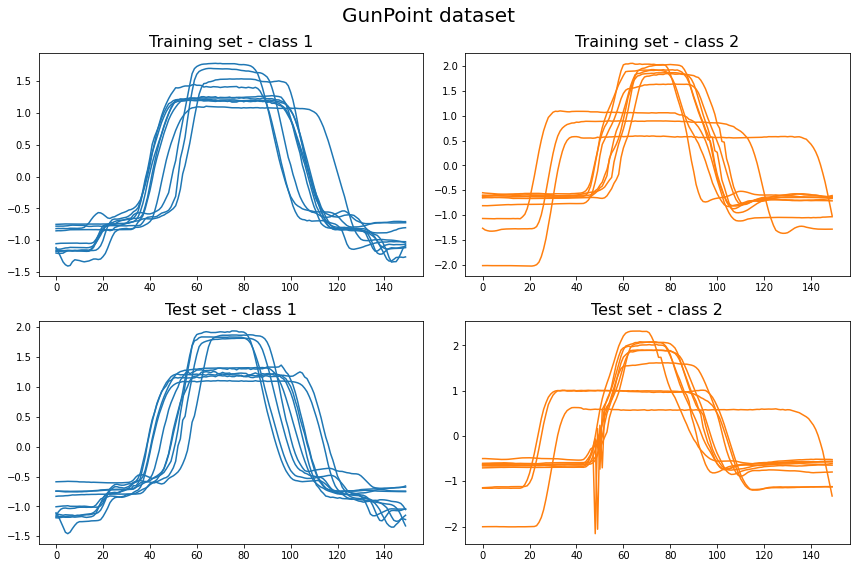

In [5]:
n_samples_per_plot = 10
color_class = ['C0', 'C1']

plt.figure(figsize=(12, 8))

for i, (X, y, set_, class_) in enumerate(zip(
    [X_train, X_train, X_test, X_test],
    [y_train, y_train, y_test, y_test],
    ['Training', 'Training', 'Test', 'Test'],
    [1, 2, 1, 2]
)):
    plt.subplot(2, 2, i + 1)
    for j in range(n_samples_per_plot):
        plt.plot(X[y == class_][j], color_class[class_ - 1])
    plt.title('{} set - class {}'.format(set_, class_), fontsize=16)

plt.suptitle('GunPoint dataset', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.2)
plt.show()

## Time Series Random Forest

This first section trains a time-series random forest on the training dataset and explores its accuracy on the test dataset. The training is performed while retaining OOB score. Hyper-parameters of the classifier are also displayed. 
Here, we chose to use 100 windows. This transformer extracts 3 features from each window: the mean, the standard 
deviation and the slope. This means that a total of 300 features are used as inputs for the random forest.

In [6]:
clf = TimeSeriesForest(random_state=43, oob_score=True, n_windows=100)
clf.fit(X_train, y_train)
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'min_window_size': 1,
 'n_estimators': 500,
 'n_jobs': None,
 'n_windows': 100,
 'oob_score': True,
 'random_state': 43,
 'verbose': 0}

The OOB score (here, accuracy in terms of good classification frequency) is given by:

In [7]:
clf.oob_score_

1.0

The same score can be obtained on the test dataset using the `score` method:

In [8]:
clf.score(X_test, y_test)

0.9533333333333334

In case you want to compute more sophisticated statistics on the prediction, the methods `predict`, `predict_proba`,
and `apply` compute the class prediction, the frequency of trees corresponding to each class, and the leaf index in
which the observation falls in each tree, respectively.

In [9]:
print("test predictions:", clf.predict(X_test), "\n") # mean accuracy
print("class probability for the test set:\n", clf.predict_proba(X_test), "\n")
print("leaf index in each tree for observations in the test set:\n", clf.apply(X_test))

test predictions: [1 2 2 1 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 1 2 1 2 1 2 1 1 2 2 1 2 2 1 1 1 1
 1 1 2 1 2 1 1 2 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 1 2 1 1 2 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 1 2 1 2 2 1 2 2 1 1 2 1 1 2 2 1 1 2 1 2 2
 2 1 2 1 1 2 1 1 2 1 2 2 2 1 2 1 1 2 2 2 2 1 1 1 2 1 2 1 1 2 1 1 2 1 2 1 2
 2 1] 

class probability for the test set:
 [[0.922 0.078]
 [0.03  0.97 ]
 [0.12  0.88 ]
 [0.978 0.022]
 [0.508 0.492]
 [0.076 0.924]
 [0.924 0.076]
 [0.028 0.972]
 [0.17  0.83 ]
 [0.394 0.606]
 [0.676 0.324]
 [0.926 0.074]
 [0.134 0.866]
 [0.63  0.37 ]
 [0.994 0.006]
 [0.878 0.122]
 [0.538 0.462]
 [0.134 0.866]
 [0.072 0.928]
 [0.02  0.98 ]
 [0.764 0.236]
 [0.018 0.982]
 [0.596 0.404]
 [0.47  0.53 ]
 [0.73  0.27 ]
 [0.246 0.754]
 [0.782 0.218]
 [0.826 0.174]
 [0.242 0.758]
 [0.48  0.52 ]
 [0.748 0.252]
 [0.046 0.954]
 [0.128 0.872]
 [0.698 0.302]
 [0.71  0.29 ]
 [0.942 0.058]
 [0.914 0.086]
 [0.856 0.144]
 [0.944 0.056]
 [0.14  0.86 ]
 [0.706 0.294]
 [0.02  0.98 ]
 [0.832

The importance of each feature is obtained with (only the first 10 are displayed here):

In [10]:
clf.feature_importances_[0:10]

array([0.00077725, 0.00104341, 0.00212407, 0.00054367, 0.00015965,
       0.00027044, 0.00273057, 0.00228225, 0.00040405, 0.00180195])

Indices of the windows are given using (again only the first 10 are given):

In [11]:
clf.indices_[0:10]

array([[ 68, 121],
       [ 64, 115],
       [ 49,  76],
       [ 21, 117],
       [ 58,  92],
       [ 16, 108],
       [ 51,  82],
       [145, 150],
       [ 91, 145],
       [110, 116]])

Finally, the following code exracts the most important interval (among whose generated by the model, the one which 
has the largest importance) and displays it on two exemplars:

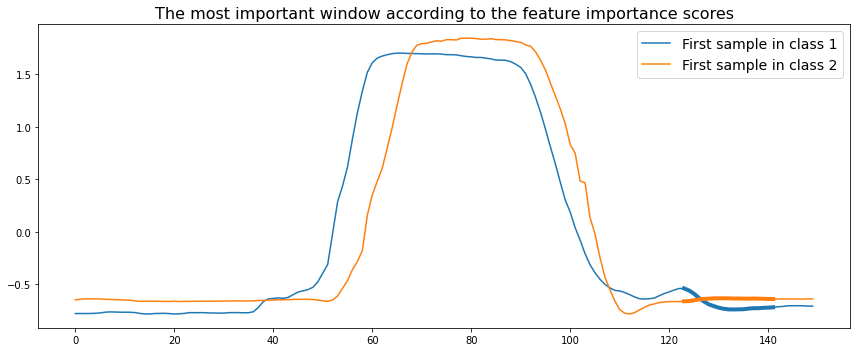

In [12]:
start_idxmax, end_idxmax = clf.indices_[
    np.argmax(clf.feature_importances_) // 3]

plt.figure(figsize=(12, 5))
plt.plot(X_train[y_train == 1][0], label='First sample in class 1')
plt.plot(np.arange(start_idxmax, end_idxmax),
         X_train[y_train == 1][0, start_idxmax:end_idxmax],
         color='C0', lw=4)

plt.plot(X_train[y_train == 2][0], label='First sample in class 2')
plt.plot(np.arange(start_idxmax, end_idxmax),
         X_train[y_train == 2][0, start_idxmax:end_idxmax],
         color='C1', lw=4)

plt.legend(loc='best', fontsize=14)
plt.title('The most important window according to the feature importance '
          'scores', fontsize=16)
plt.tight_layout()
plt.show()

## BOSS random forest

This section tries to mimic the approach described in [Schäfer, 2015] which uses the BOSS transformation to further
train a random forest.

First, I fit the BOSS model on the training dataset and then, I obtain the transformation for the test dataset. 
Hyper-parameters of the BOSS are completely arbitrary here (you can probably do better). The size of the two 
transformations are thus checked and the first three transformed observations of the training set are also 
displayed:

In [13]:
boss = BOSS(word_size=2, n_bins=4, window_size=12, sparse=False)
X_train_boss = boss.fit_transform(X_train)
X_test_boss = boss.transform(X_test)
print(X_train_boss.shape)
print(X_test_boss.shape)
X_train_boss[0:10]

(50, 16)
(150, 16)


array([[1, 0, 0, 1, 1, 5, 5, 2, 1, 0, 0, 2, 2, 2, 2, 1],
       [1, 1, 0, 1, 1, 5, 5, 2, 1, 1, 0, 2, 2, 1, 1, 1],
       [0, 3, 3, 2, 2, 4, 2, 3, 1, 0, 0, 2, 2, 3, 2, 1],
       [1, 3, 3, 2, 2, 3, 2, 4, 1, 0, 0, 2, 2, 2, 1, 1],
       [0, 0, 0, 0, 2, 8, 7, 3, 1, 0, 0, 2, 2, 3, 2, 1],
       [1, 1, 1, 1, 1, 3, 3, 2, 1, 0, 0, 2, 2, 1, 0, 1],
       [2, 4, 3, 4, 1, 0, 0, 2, 2, 8, 6, 1, 0, 0, 0, 0],
       [1, 1, 2, 1, 1, 0, 0, 0, 2, 9, 9, 1, 0, 0, 0, 0],
       [1, 2, 3, 2, 0, 0, 1, 2, 2, 2, 0, 1, 1, 5, 4, 0],
       [3, 3, 4, 3, 1, 1, 0, 2, 2, 2, 0, 1, 2, 4, 3, 0]])

In [14]:
clf2 = RandomForestClassifier(random_state=43, oob_score=True, n_estimators=500)
clf2.fit(X_train_boss, y_train)
print("forest hyper-parameters:\n", clf2.get_params(), "\n")
print("Mean training OOB accuracy:", clf2.oob_score_, "\n")
print("Mean test accuracy:", clf2.score(X_test_boss, y_test), "\n")
print("test predictions:\n", clf2.predict(X_test_boss), "\n")
print("class probability for the test set:\n", clf2.predict_proba(X_test_boss), "\n")
print("leaf index in each tree for observations in the test set:\n", clf2.apply(X_test_boss), "\n")

forest hyper-parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 43, 'verbose': 0, 'warm_start': False} 

Mean training OOB accuracy: 0.88 

Mean test accuracy: 0.9133333333333333 

test predictions:
 [1 2 2 1 1 2 1 2 2 1 1 1 2 1 1 1 1 2 2 2 1 2 2 1 1 2 1 1 2 2 2 2 2 1 1 1 1
 1 1 2 2 2 1 1 2 1 2 1 2 2 1 2 2 2 2 1 2 2 1 2 1 2 1 1 2 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 1 2 1 2 2 1 2 2 1 1 2 1 1 2 2 1 1 2 2 2 2
 2 1 2 1 1 2 1 1 2 1 2 2 2 1 2 1 1 2 2 2 2 1 1 1 2 1 2 1 1 2 2 1 2 1 2 1 2
 2 1] 

class probability for the test set:
 [[0.906 0.094]
 [0.028 0.972]
 [0.004 0.996]
 [0.97  0.03 ]
 [0.68  0.32 ]
 [0.034 0.966]
 [0.93  0.07 ]
 [0.34  0.66 ]
 [0.288 0.712]
 [0.53 

The accuracy is very similar but the direct interpretation of the importance is lost.

## References

Deng, H., Runger, G., Tuv, E., and Martyanov, V. (2013). A time series forest for classification and feature 
extraction. *Information Science*, 239:142-153.

Schäfer, P. (2015). The BOSS is concerned with time series classification in the presence of noise. *Data Mining and
Knowledge Discovery*, 29(6):1505-1530.

## License

Most of the original code has been obtained from the [`pyts`](https://pyts.readthedocs.io/en/stable/index.html)
documentation, by Johann Faouzi <johann.faouzi@gmail.com> and was released under BSD-3-Clause license.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
  <img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
</a>
<br />
The current work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
  Creative Commons Attribution 4.0 International License
</a>.

The code is distributed under 
[GPL-3 licence](https://www.gnu.org/licenses/gpl-3.0.html).

## Session information

In [15]:
session_info.show()